In [1]:
from deep_traffic_generation.linear_vae import LinearVAE
from deep_traffic_generation.core.datasets import TrafficDataset
from deep_traffic_generation.core.builders import CollectionBuilder, IdentifierBuilder, TimestampBuilder
from deep_traffic_generation.core.utils import traffic_from_data

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import numpy as np

from traffic.core.projection import EuroPP

import warnings
warnings.filterwarnings("ignore")

/home/adrien/.conda/envs/traffic/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: DeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  warnings.warn(*args, **kwargs)
/home/adrien/.conda/envs/traffic/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:572: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.object, string),
/home/adrien/.conda/envs/traffic/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:573: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warni

Traffic dataset.

In [2]:
dataset = TrafficDataset(
    "../deep_traffic_generation/data/denoised_v3.pkl",
    features=["latitude", "longitude", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
)
dataset

Dataset TrafficDataset
    Number of datapoints: 17914
    File location: ../deep_traffic_generation/data/denoised_v3.pkl
    MinMaxScaler(feature_range=(-1, 1))

Model.

In [3]:
model = LinearVAE.load_from_checkpoint(
    "../deep_traffic_generation/lightning_logs/linear_vae/version_0/checkpoints/epoch=197-step=2375.ckpt",
    hparams_file="../deep_traffic_generation/lightning_logs/linear_vae/version_0/hparams.yaml",
    input_dim = dataset.data.shape[1],
    scaler = dataset.scaler,
)
model.eval()

LinearVAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=800, out_features=400, bias=True)
    )
    (z_loc): Linear(in_features=400, out_features=20, bias=True)
    (z_log_var): Linear(in_features=400, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=20, out_features=400, bias=True)
      (1): Linear(in_features=400, out_features=800, bias=True)
    )
  )
)

In [4]:
x, y = dataset[1]
x = x.unsqueeze(0)
z, x_hat = model(x)

In [5]:
x.size()

torch.Size([1, 800])

In [6]:
x_hat.size()

torch.Size([1, 800])

In [7]:
z.size()

torch.Size([1, 20])

In [8]:
# lat1 = x.squeeze().numpy()[:, 0]
# lat2 = x_hat.detach().squeeze().numpy()[:, 0]

# plt.plot(np.arange(200), lat1, c="purple")
# plt.plot(np.arange(200), lat2, c="orange")
# plt.show()

In [9]:
# lon1 = x.squeeze().numpy()[:, 1]
# lon2 = x_hat.detach().squeeze().numpy()[:, 1]

# plt.plot(np.arange(200), lon1)
# plt.plot(np.arange(200), lon2)
# plt.show()

In [10]:
data = np.concatenate((x.numpy(), x_hat.detach().numpy()))
data.shape

(2, 800)

In [11]:
n_samples = data.shape[0]
data = dataset.scaler.inverse_transform(data)
n_obs = int(data.shape[1] / len(model.hparams.features))
builder = CollectionBuilder(
    [IdentifierBuilder(n_samples, n_obs), TimestampBuilder()]
)
traffic = traffic_from_data(
    data, model.hparams.features, builder=builder
)
traffic

,count
flight_id,
0,200
1,200


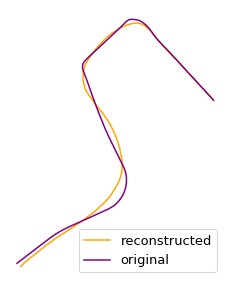

In [12]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(
        1, figsize=(5, 5), subplot_kw=dict(projection=EuroPP())
    )
    traffic[1].plot(ax, c="orange", label="reconstructed")
    traffic[0].plot(ax, c="purple", label="original")
    ax.legend()

In [13]:
traffic[0].chart("altitude").encode()

alt.Chart(...)

In [14]:
traffic[1].chart("altitude").encode()

alt.Chart(...)